# Mount drive and bucket
Todo: Remove in public version

In [1]:
# Check if the notebook is run in Google Colab
import sys

COLAB = 'google.colab' in sys.modules

In [2]:
import sys
import datetime
import logging

nblog = open(f"/content/bigdata/nb_{datetime.datetime.utcnow().strftime('%Y%m%d_%H%M')}.log", "a+")
print(nblog)
sys.stdout.echo = nblog
sys.stderr.echo = nblog

#get_ipython().log.handlers[0].stream = nblog
#get_ipython().log.setLevel(logging.INFO)

%autosave 60

<_io.TextIOWrapper name='/content/bigdata/nb_20230217_1046.log' mode='a+' encoding='UTF-8'>


Autosaving every 60 seconds


In [3]:
# if COLAB:
#   from google.colab import drive
#   drive.mount('/content/drive')

In [4]:
if COLAB:
  from google.colab import auth
  auth.authenticate_user()
else:
    print("Run the command!")
  #Todo #bring the command inside the notebook
  #run this terminal inside docker: gcloud auth login b.girsule@gmail.com --no-launch-browser

Run the command!


In [5]:
# Todo: Check if possible in local docker
# from google.cloud import storage

In [6]:
# Check if the tf version is 2.10.0, this is required to use the 'ignore_class' in the  SparseCategoricalCrossentropy
import tensorflow as tf

if '2.10.0' != tf.__version__:
  !pip uninstall tensorflow -y
  !pip install tensorflow-gpu==2.10.0
  please_restart_the_runtime
else:
  print("TF Version is 2.10.0, ok!")

2023-02-17 10:46:42.269285: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-17 10:46:42.391776: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-17 10:46:43.011141: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-17 10:46:43.011199: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

TF Version is 2.10.0, ok!


In [7]:
from tensorflow import keras
# import tensorflow_gcs_config
from tensorflow.python.lib.io import file_io

from keras.layers import Input, Dense #, ReLU, Add, Flatten, Concatenate, LayerNormalization, UpSampling2D, Activation, LSTM, Multiply, Dropout, Reshape, Permute, BatchNormalization, MaxPooling1D, AveragePooling1D, MaxPooling3D, AveragePooling2D, LayerNormalization, MaxPooling2D
from keras.models import Model
from keras.optimizers import Adam

In [8]:
import os
from os import listdir
from os.path import isfile, join

In [9]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import gc

In [10]:
# Set the google cloud bucket data
project_id = 'tweetprediction'
bucket_name = 'crypto_nlp_training'

In [11]:
# Set the checkpoint path for saving train progress
if COLAB:
    CHECKPOINT_PATH = f"gs://{bucket_name}/chk/"
else:
    CHECKPOINT_PATH = f"/content/bigdata/chk/"

In [12]:
# Check if the notebook is run in google colab, if so, clone the repo
if COLAB:
    print("Running in Colab")

    # Clone the whole repo to get all data and code if not already done
    if not os.path.exists("/content/CryptoCrystalBall"):
      !git clone https://github.com/girsigit/CryptoCrystalBall

      # cd into the notebooks directory --> Necessary to match all paths for importing
    #%cd /content/CryptoCrystalBall/JupyterDocker/notebooks
    %cd /content

In [13]:
# Try importing the Ta-Lib library, if this fails, try to install it and
# import it again afterwards
try:
    import talib
except:
    !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
    !tar -xzvf ta-lib-0.4.0-src.tar.gz
    %cd ta-lib
    !./configure --prefix=/usr
    !make
    !make install
    !pip install Ta-Lib
    %cd ..

    import talib

In [14]:
try:
  from transformers import TFRobertaModel, RobertaConfig
except:
  # Important!: Version 4.23 does not work on TPU
  !pip install transformers==4.22

  from transformers import TFRobertaModel, RobertaConfig

In [15]:
# !pip uninstall -y tensorboard-plugin-profile

In [16]:
# # Required to do profiling
# !pip install tensorboard-plugin-profile

In [17]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

---
# Add custom import path for DataStreamCreator and IndicatorCalculator

These libs are not in the standard python directory, so their paths have to be added to the import paths

In [18]:
# # Get the current directory
# current_dir = os.getcwd()
# current_dir_splitted = current_dir.split(os.sep)

# Todo: is inside /content/CB in local docker
current_dir_splitted = ["", "content"]
current_dir_splitted

['', 'content']

In [19]:
# Create the import directories for the DataStreamCreator and the IndicatorCalculator
dsc_dir = '/content/CryptoCrystalBall/DataStreamCreator'
print(f"dsc_dir: {dsc_dir}")

ind_dir = '/content/CryptoCrystalBall/IndicatorCalculator'
print(f"ind_dir: {ind_dir}")

# Add them to the import paths
sys.path.insert(0, dsc_dir)
sys.path.insert(0, ind_dir)

dsc_dir: /content/CryptoCrystalBall/DataStreamCreator
ind_dir: /content/CryptoCrystalBall/IndicatorCalculator


In [20]:
# Import the actual classes
from IndicatorCalculator import IndicatorCalculator
import DataStreamCreator

---
# Define all the parameters and variables

In [21]:
# Define the tick data path
DATA_PATH = os.path.join(os.sep, *current_dir_splitted, 'DemoData')
print(f"DATA_PATH: {DATA_PATH}")

DATA_PATH: /content/DemoData


In [22]:
# Define the chart image save path
IMG_SAVE_PATH = os.path.join(os.sep, *current_dir_splitted, 'Documentation', 'Images')
print(f"IMG_SAVE_PATH: {IMG_SAVE_PATH}")

IMG_SAVE_PATH: /content/Documentation/Images


In [23]:
# Define a global random seed
RANDOM_SEED = 42+17

# Set the seed in np
np.random.seed(RANDOM_SEED)

In [24]:
# X_BLOCK_LENGHT defines how far into the past a 'slice of a chart' shall be
# See: https://github.com/girsigit/CryptoCrystalBall/tree/main/DataStreamCreator#xblockgenerator
X_BLOCK_LENGHT = 512

In [25]:
# How many examples shall be processed at the same time, limited by GPU memory
BATCH_SIZE = 5

In [26]:
# A fixed number of features is used
FEATURES = 160

In [27]:
# Finanical indicator timespans
# See: https://github.com/girsigit/CryptoCrystalBall/tree/main/IndicatorCalculator
SHORTSPAN = 6
MIDSPAN = 48
LONGSPAN = 120

In [28]:
# Additional settings for the data stream
# For this notebook, the calculation of pattern indicators is turned off
DATA_STREAM_PARAMETERS = {
    "calcPatternIndicators": False, # No patterns are used
    "calcVolumeInidators": False, # No volume indicators, these are wide spread and may disturb the classifer
    "dropna": True # Drop all tick/indicator table rows containing nan values instead of just replacing them by 0 (which would lead to wrong predictions)
}

In [29]:
# NLP token configuration
BOS_TOKEN_ID = 0
PAD_TOKEN_ID = 1
EOS_TOKEN_ID = 2
MASK_TOKEN_ID = 3

MLM_MASK_FACTOR = 0.15

In [30]:
# Vocab size configuration
# The feature vector to integer classifier model has a 5 digit output, therefore the vocab size would be 100000
# As this is too much, the categories are rounded --> Todo: Create better classifier model

VOCAB_SIZE = 10000

# Load the train dataset

In [31]:
# Check if the dataset already has been copy, if not, copy it
if not os.path.exists("/content/dataset") or not os.path.exists("/content/dataset/Train"):
  !mkdir /content/dataset
  !mkdir /content/dataset/Train
  !gsutil -m cp -r gs://cryptocrystalball_public/CryptoDataset/Hourly/significant_currencies.txt /content/dataset/significant_currencies.txt
  !gsutil -m cp -r gs://cryptocrystalball_public/CryptoDataset/Hourly/Train/* /content/dataset/Train/

In [32]:
#@markdown ### Use only significant currencies
#@markdown Load a manually defined list of significant currencies (`significant_currencies.txt`).
#@markdown This list contains no currencies which little or no volume or price movement, to
#@markdown avoid training on data sample which would never be used to trade on in a real 
#@markdown application.

#@markdown If enabled, only currency pairs with the base currency USDT are laoded,
#@markdown this is important to prevent interference between different cryptocurrencies.
#@markdown For example, in `BTC-ETH.csv`, there is influence of both the BTC and the ETH price, but we want to predict trade signals based on a 'real' currency (USDT is kind of the same as USD).

significant_only = True #@param {type:"boolean"}

if significant_only:
  with open("/content/dataset/significant_currencies.txt") as f:
    SIGNIFICANT_CURRS = f.read().splitlines()

  print(f"Loaded {len(SIGNIFICANT_CURRS)} significant files names.")

Loaded 121 significant files names.


In [33]:
# Get train file names - Only pick the ones ending with -USDT to prevent
# influence between different currencies
TRAIN_PATH = "/content/dataset/Train"

# Get all file names
TRAIN_FILES = [os.path.join(TRAIN_PATH,f) for f in listdir(TRAIN_PATH) if isfile(join(TRAIN_PATH, f)) and ".csv" in f ]

# Filter for significant currencies only
if significant_only:
  TRAIN_FILES = [f for f in TRAIN_FILES if f.split("/")[-1].replace(".csv","") in SIGNIFICANT_CURRS]

# Filter for USDT-based ones only
TRAIN_FILES = [f for f in TRAIN_FILES if "-USDT" in f]

# Sort them (as a stable basis for randomizing afterwards)
TRAIN_FILES = sorted(TRAIN_FILES)

print(f"The train dataset contains {len(TRAIN_FILES)} files.")
print(TRAIN_FILES[:3])

The train dataset contains 121 files.
['/content/dataset/Train/1INCH-USDT.csv', '/content/dataset/Train/4ART-USDT.csv', '/content/dataset/Train/AAVE-USDT.csv']


# Load the classifier model

In [34]:
# Copy the feature vector to four float classifier model
# Also copy the digit limits
if not os.path.exists("/content/bottleneckToFourFloatModel.h5"):
  !gsutil -m cp -r gs://crypto_nlp_training/four_float_to_int/bottleneckToFourFloatModel.h5 /content/bottleneckToFourFloatModel.h5
  !gsutil -m cp -r gs://crypto_nlp_training/four_float_to_int/digitLimits.npy /content/digitLimits.npy

In [35]:
# Load the model
with tf.device('/CPU:0'):
    fourFloatClassifierModel = keras.models.load_model("/content/bottleneckToFourFloatModel.h5")
    fourFloatClassifierModel.summary(line_length=220)

Model: "NNClassifierBottleneckToFourFloat"
____________________________________________________________________________________________________________________________________________________________________________________________________________________________
 Layer (type)                                                                                      Output Shape                                                                            Param #                          
 inputTicksAndIndicators (InputLayer)                                                              [(None, 512, 160)]                                                                      0                                
                                                                                                                                                                                                                            
 tf.expand_dims_1 (TFOpLambda)                                           

2023-02-17 10:46:44.691360: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-17 10:46:44.722667: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-17 10:46:44.722858: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-17 10:46:44.723663: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [36]:
# Load the digit limits
digitLimits = np.load("/content/digitLimits.npy")

# Load the class weights

In [37]:
# # Copy the class weights
if not os.path.exists("/content/class_weights.npy"):
  !gsutil -m cp -r gs://crypto_nlp_training/four_float_to_int/class_weights.npy /content/class_weights.npy

# Load the class weights
cwnp = np.load("/content/class_weights.npy")

CLASS_WEIGHTS_DICT = {}

for i in range(cwnp.shape[0]):
  CLASS_WEIGHTS_DICT[i] = cwnp[i]

CLASS_WEIGHTS_DICT

Copying gs://crypto_nlp_training/four_float_to_int/class_weights.npy...
/ [1/1 files][ 78.2 KiB/ 78.2 KiB] 100% Done                                    
Operation completed over 1 objects/78.2 KiB.                                     


{0: 1.0,
 1: 1.0,
 2: 1.0,
 3: 1.0,
 4: 1.0,
 5: 1.0,
 6: 1.0,
 7: 1.0,
 8: 1.0,
 9: 1.0,
 10: 1.0,
 11: 1.0,
 12: 1.0,
 13: 1.0,
 14: 1.5366002344665886,
 15: 3.810232558139535,
 16: 2.932259507829978,
 17: 1.486077097505669,
 18: 1.4777001127395717,
 19: 1.0,
 20: 1.0,
 21: 1.0,
 22: 2.56,
 23: 3.098628841607565,
 24: 1.1309059534081105,
 25: 3.7664367816091953,
 26: 1.927529411764706,
 27: 0.8222835633626098,
 28: 0.8021542227662178,
 29: 2.6969547325102883,
 30: 1.0,
 31: 1.0,
 32: 1.6868983268983269,
 33: 0.7576416184971099,
 34: 1.0561804995970991,
 35: 0.71624043715847,
 36: 0.584620874219447,
 37: 0.8279974731522426,
 38: 1.678258642765685,
 39: 3.6207734806629834,
 40: 5.77409691629956,
 41: 4.664483985765124,
 42: 0.9651840942562592,
 43: 1.0604530744336569,
 44: 0.3078252700798497,
 45: 0.6488712871287129,
 46: 0.2683701883701884,
 47: 0.18051508056741494,
 48: 1.4246956521739131,
 49: 1.0,
 50: 1.0,
 51: 1.5348009367681499,
 52: 1.4108934337997847,
 53: 0.8779102478231748,


---
# Prepare data source

For training a neural network, first the data source has to be prepared. For this purpose, the method `FileListToDataStream` from the `DataStreamCreator` class is used. This method creates a stream of `X-Block` and `y-data` arrays out of a list of .csv file names, pointing to tick tables (called `EXAMPLE_FILE_PATHS` in this example). For details about `X-Blocks` and `y-data`, please refer to the documentation of the `XBlockGenerator` and the `YDataGenerator` under https://github.com/girsigit/CryptoCrystalBall/tree/main/DataStreamCreator.

<br>

Target values (y-data) from the data generator would not be necessary in this notebook, but since it cannot be switched off, the future direction and its derviation of the price have been chosen in `Y_TYPE_DICT` since they are not expensive to compute. A switch flag will be added in a future release.

In [38]:
# Set direction and derivation information as y target
# Both y values (direction & derivation) are in the interval [-1.0,1.0]

Y_TYPE_DICT = copy.deepcopy(DataStreamCreator.YDataGenerator.PARAM_DICT_TEMPLATE_Y_DATA_TYPE_DIRECTION_FLOAT)
Y_TYPE_DICT

{'dataType': 0,
 'direction_ma_timespan': 200,
 'derivation_ma_timespan': 100,
 'direction_derivation_shift_span': 0}

In [39]:
# Calculate how many word shall be replaced
replace_index_number = int(np.round(X_BLOCK_LENGHT * MLM_MASK_FACTOR))
replace_index_number

77

In [40]:
# Create random indices, to replace 'words' with MASK_TOKEN_I
mask_positions = np.round(np.random.rand(BATCH_SIZE, replace_index_number) * X_BLOCK_LENGHT).astype(int)
print(mask_positions.shape)
mask_positions

(5, 77)


array([[473,  81, 444,  43, 294, 144, 131, 289, 113, 332, 321, 210, 206,
        230, 120,  69,  54, 242,  58, 146, 429, 161,  39, 394, 132, 478,
        414, 172, 252, 114, 222, 330, 492, 225, 225, 328, 468, 285, 274,
        227,  71, 479, 327, 486, 232, 199, 315, 344, 391, 159, 151, 103,
        146, 358, 473, 175, 359, 328,  22, 379,  10, 416, 145, 224, 476,
        277, 462, 201, 304, 459,  83, 415,  95, 324, 263, 373,  19],
       [467, 395, 491, 116, 346, 184, 134, 201, 388, 199, 469, 323, 508,
        370, 246, 115, 337, 297, 302,  82, 410, 317, 441,  73, 279, 187,
        276, 137, 395, 454,   6, 154,  17, 113, 130,  14, 139, 283, 122,
        280, 115, 336, 408, 510, 327, 479, 404, 436,  41, 275, 352, 230,
        479, 332,  58, 416, 282, 475, 331, 316,  25, 207, 228, 290,  87,
        253, 387, 371, 118, 266, 302, 178, 292, 472, 122, 347, 328],
       [456, 250, 215, 242, 115, 234, 454, 242, 174,  73, 460, 128, 366,
        429, 299, 322,  99,  84,  65, 511, 145, 264,  97, 3

(array([30., 40., 45., 33., 38., 39., 40., 40., 40., 40.]),
 array([  0. ,  51.1, 102.2, 153.3, 204.4, 255.5, 306.6, 357.7, 408.8,
        459.9, 511. ]),
 <BarContainer object of 10 artists>)

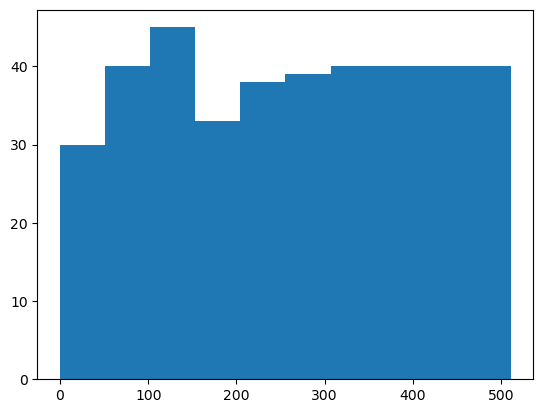

In [41]:
plt.hist(mask_positions.flatten())

In [42]:
# Method for normalizing the distribution of one digit
def NormalizeDigitDistribution(dataIn, categoryLimitValues):
  normalizedDistribution = np.empty(dataIn.shape)

  for i, lim in enumerate(categoryLimitValues):
    normalizedDistribution[(dataIn >= lim[0]) & (dataIn <= lim[1])] = i

  return normalizedDistribution

In [43]:
# Method for converting a four-float vector into an integer 'word' in the range of 0-10000
def ConvertFourFloatDataToWords(fourFloatIn, digitLimits):
  # Normalize each digit
  digitsNormalized = []

  for digit in range(4):
    digitsNormalized.append(
        NormalizeDigitDistribution(fourFloatIn[:,:,digit], digitLimits[digit])
        )
    
  # Combine the digits to one integer (creating the 'word')
  intData = digitsNormalized[0] * 1000 + digitsNormalized[1] * 100 + digitsNormalized[2] * 10 + digitsNormalized[3]
  intData = intData.astype(np.int32)  

  del digitsNormalized

  return intData

In [44]:
# A python generator function has to be applied on the dataStream

def pythonGeneratorMLMTraining():
  # Initialize the FileListToDataStream generator
  dataStreamTraining = DataStreamCreator.FileListToDataStream(fileList = TRAIN_FILES,
                                                      batch_size = BATCH_SIZE,
                                                      X_Block_lenght = X_BLOCK_LENGHT,
                                                      y_type_dict=Y_TYPE_DICT,
                                                      shuffle=True,
                                                      parallel_generators = BATCH_SIZE,
                                                      random_seed = RANDOM_SEED,
                                                      **DATA_STREAM_PARAMETERS
                                                      )
  
  # Calculate how many word shall be replaced
  mask_number = int(np.round(X_BLOCK_LENGHT * MLM_MASK_FACTOR))
  logging.info(f"In each batch of X-Blocks, {mask_number*BATCH_SIZE} elements will be randomly masked. This is an average of {mask_number} per X-Block")

  # This while has to integrated into the FileListToDataStream method
  while True:  
    try:
      ne = next(dataStreamTraining)
      _X = ne['X']

      # Convert the X-Block into a sentence
      with tf.device('/CPU:0'):        
        four_float_sentence = fourFloatClassifierModel.predict(_X, batch_size = BATCH_SIZE, verbose = 0)
        int_sentence = ConvertFourFloatDataToWords(four_float_sentence, digitLimits)

        # _X_sentence = intClassifierModel.predict(_X, batch_size = BATCH_SIZE, verbose = 0)

      # Round to avoid too many categories
      # Todo: Better classifier model!
      # _X_sentence = np.round(_X_sentence / 10.0).astype(int)

      # Create random indices, to replace 'words' with MASK_TOKEN_I
      mask_positions = np.round(np.random.rand(BATCH_SIZE, mask_number) * X_BLOCK_LENGHT * BATCH_SIZE).astype(int)
      mask_positions[mask_positions == X_BLOCK_LENGHT * BATCH_SIZE] -= 1  # Avoid the upper array limit

      # Mask the chosen tokens
      int_sentence_masked = np.array(int_sentence).flatten()
      int_sentence_masked[mask_positions] = MASK_TOKEN_ID
      int_sentence_masked = int_sentence_masked.reshape(int_sentence.shape)

      # print(mask_positions[0,0])

      # 'Remove' all tokens that shall not be predicted from the training y data (the full sentence), so that the network can focus on the missing tokens
      # More precise: Setting them to -1 tells the loss function to ignore them
      int_sentence[int_sentence_masked != MASK_TOKEN_ID] = -1

      # Not required here, as the network shall predict back its original input
      # _y = ne['y']
      
      # Return the masked senteces as X data, the full ones are the y-data --> The network shall predict the missing tokens
      yield (int_sentence_masked, int_sentence)
    except StopIteration as si:
      logging.warning("StopIteration in pythonGenerator")
      logging.warning(si)
      return

In [45]:
# Create a Tensorflow dataset out of the python generator, which can be fed to the network
tfGenTraining = tf.data.Dataset.from_generator(pythonGeneratorMLMTraining, 
                                               output_types = (tf.int32, tf.int32),
                                               output_shapes=(
                                                   (BATCH_SIZE, X_BLOCK_LENGHT),
                                                   (BATCH_SIZE, X_BLOCK_LENGHT)
                                                   )
                                               )
tfGenTraining.prefetch(buffer_size=2)
tfGenTraining

<FlatMapDataset element_spec=(TensorSpec(shape=(5, 512), dtype=tf.int32, name=None), TensorSpec(shape=(5, 512), dtype=tf.int32, name=None))>

In [46]:
it = tfGenTraining.as_numpy_iterator()

ne = next(it)

INFO:root:File 'GOLD-USDT.csv' loaded, 120 left
INFO:root:File 'FIL-USDT.csv' loaded, 119 left
INFO:root:File 'OCEAN-USDT.csv' loaded, 118 left
INFO:root:File 'COMP-USDT.csv' loaded, 117 left
INFO:root:File 'VLX-USDT.csv' loaded, 116 left
INFO:root:In each batch of X-Blocks, 385 elements will be randomly masked. This is an average of 77 per X-Block


In [47]:
ne[0]

array([[4443, 4443, 4443, ..., 5764,    3, 6751],
       [4443,    3, 4443, ...,    3, 5605, 7704],
       [   3, 4443, 4443, ..., 3510,    3, 3610],
       [4443, 4443, 4443, ..., 9653, 7741, 6730],
       [   3, 4443, 4443, ..., 2196, 2197, 9579]], dtype=int32)

In [48]:
ne[1]

array([[  -1,   -1,   -1, ...,   -1, 5653,   -1],
       [  -1, 4443,   -1, ..., 4606,   -1,   -1],
       [4443,   -1,   -1, ...,   -1, 2510,   -1],
       [  -1,   -1,   -1, ...,   -1,   -1,   -1],
       [4443,   -1,   -1, ...,   -1,   -1,   -1]], dtype=int32)

(array([532., 196., 241., 236., 343., 236., 205., 201., 183., 187.]),
 array([3.000e+00, 1.001e+03, 1.999e+03, 2.997e+03, 3.995e+03, 4.993e+03,
        5.991e+03, 6.989e+03, 7.987e+03, 8.985e+03, 9.983e+03]),
 <BarContainer object of 10 artists>)

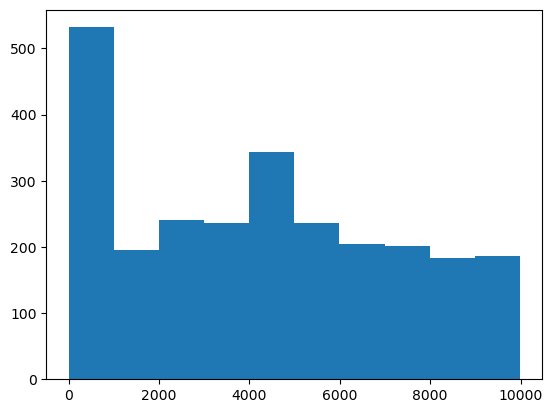

In [49]:
plt.hist(ne[0].flatten())

(array([2241.,   29.,   39.,   40.,   52.,   31.,   43.,   27.,   36.,
          22.]),
 array([-1.0000e+00,  9.9070e+02,  1.9824e+03,  2.9741e+03,  3.9658e+03,
         4.9575e+03,  5.9492e+03,  6.9409e+03,  7.9326e+03,  8.9243e+03,
         9.9160e+03]),
 <BarContainer object of 10 artists>)

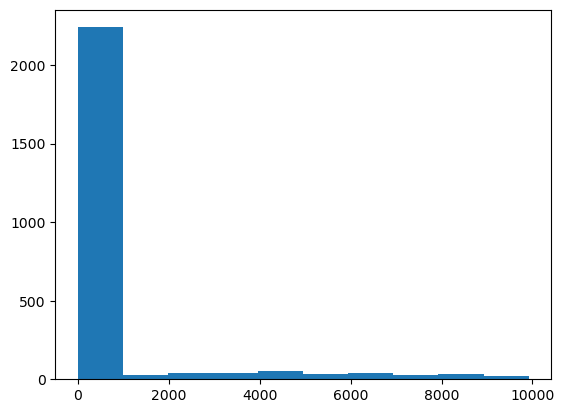

In [50]:
plt.hist(ne[1].flatten())

In [51]:
wurst = np.array(ne[1])
wurst[ne[0] != MASK_TOKEN_ID] = -1
wurst

array([[  -1,   -1,   -1, ...,   -1, 5653,   -1],
       [  -1, 4443,   -1, ..., 4606,   -1,   -1],
       [4443,   -1,   -1, ...,   -1, 2510,   -1],
       [  -1,   -1,   -1, ...,   -1,   -1,   -1],
       [4443,   -1,   -1, ...,   -1,   -1,   -1]], dtype=int32)

In [52]:
np.sum(ne[0][0,:] == 3)

64

---
# Create the NLP model

In [53]:
cfg = RobertaConfig()

cfg.vocab_size = VOCAB_SIZE
cfg.max_position_embeddings = X_BLOCK_LENGHT + 1

cfg.bos_token_id = BOS_TOKEN_ID
cfg.pad_token_id = PAD_TOKEN_ID
cfg.eos_token_id = EOS_TOKEN_ID

cfg

RobertaConfig {
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 513,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 10000
}

In [54]:
#@title CreateModelRobertaMLMTraining
def CreateModelRobertaMLMTraining():

  # A sentence as input
  inputSentence = Input(shape=(X_BLOCK_LENGHT), name='input', dtype='int32')
  
  # The NLP model
  nlp = TFRobertaModel(cfg)(inputSentence)

  # A dense layer to predict back the full sentence
  predicted_sentence = Dense(VOCAB_SIZE, activation='softmax', name="Categories")(nlp['last_hidden_state'])

  outputs = [predicted_sentence]

  # And combine it all in a model object
  model = Model(inputs=inputSentence, outputs=outputs, name='RobertaMLMTraining_1')

  return model

model = CreateModelRobertaMLMTraining()
model.summary(line_length=220)

Model: "RobertaMLMTraining_1"
____________________________________________________________________________________________________________________________________________________________________________________________________________________________
 Layer (type)                                                                                      Output Shape                                                                            Param #                          
 input (InputLayer)                                                                                [(None, 512)]                                                                           0                                
                                                                                                                                                                                                                            
 tf_roberta_model (TFRobertaModel)                                                    

### Todo: Check if weighted classed are required

In [55]:
# #@title Load the class weights
# with file_io.FileIO('gs://ticks_with_indicators_with_volume/sentences/set2/weightArray.npy', mode='rb') as input_f:
#   with file_io.FileIO('/content/weightArray.npy', mode='wb+') as output_f:
#     output_f.write(input_f.read())

# CLASS_WEIGHTS = np.empty((1,1,1024))
# CLASS_WEIGHTS[0,0,:] = np.load('/content/weightArray.npy')

In [56]:
# plt.plot(CLASS_WEIGHTS[0,0,:])
# plt.yscale("log")

In [57]:
# CLASS_WEIGHTS_TF_CONST = tf.constant(tf.convert_to_tensor(CLASS_WEIGHTS,dtype=tf.float32))

In [58]:
#@title CreateModelRobertaMLMTrainingWeighted - Todo change to new style
def CreateModelRobertaMLMTrainingWeighted():

  # Build your model input
  inputSentence = Input(shape=(X_LOOKBACK_CNT), name='input', dtype='int32')
  
  nlp = TFRobertaModel(cfg)(inputSentence)

  categories = Dense(1024, activation='softmax', name="Categories")(nlp['last_hidden_state'])
  categories_weighted = tf.multiply(categories, CLASS_WEIGHTS_TF_CONST)

  outputs = [categories_weighted]

  mnamesuffix = "_1"

  # And combine it all in a model object
  model = Model(inputs=inputSentence, outputs=outputs, name='ModelRobertaMLMTrainingWeighted'+mnamesuffix)

  return model

# model = CreateModelRobertaMLMTrainingWeighted()
# model.summary(line_length=220)

In [59]:
#@title CreateModelRobertaMLMTrainingDropout - Todo change to new style
def CreateModelRobertaMLMTrainingDropout():

  # Build your model input
  inputSentence = Input(shape=(X_LOOKBACK_CNT), name='input', dtype='int32')
  
  nlp = TFRobertaModel(cfg, name="Roberta")(inputSentence)

  categories = Dense(VOCAB_SIZE, activation='softmax', name="Categories")(nlp['last_hidden_state'])
  drp = Dropout(0.15, name="CategoriesDropout")(categories)

  # categories_weighted = tf.multiply(drp, CLASS_WEIGHTS_TF_CONST)

  outputs = [drp]

  mnamesuffix = "_1"

  # And combine it all in a model object
  model = Model(inputs=inputSentence, outputs=outputs, name='ModelRobertaMLMTrainingDropout'+mnamesuffix)

  return model

# model = CreateModelRobertaMLMTrainingDropout()
# model.summary(line_length=220)

In [60]:
#@title CreateModelRobertaLastWordPrediction - Todo change to new style
def CreateModelRobertaLastWordPrediction():

  # Build your model input
  inputSentence = Input(shape=(X_LOOKBACK_CNT), name='input', dtype='int32')
  
  nlp = TFRobertaModel(cfg, name="Roberta")(inputSentence)

  flat = Flatten(name="FlattenNLP")(nlp['last_hidden_state'])
  lastWord = Dense(VOCAB_SIZE, activation='softmax', name="Categories", dtype=tf.float32)(flat)

  outputs = [lastWord]

  mnamesuffix = "_1"

  # And combine it all in a model object
  model = Model(inputs=inputSentence, outputs=outputs, name='ModelRobertaLastWordPrediction'+mnamesuffix)

  return model

# model = CreateModelRobertaLastWordPrediction()
# model.summary(line_length=220)

# Train the model

### Train strategy in the paper
https://huggingface.co/roberta-base

The model was trained on 1024 V100 GPUs for 500K steps with a batch size of 8K and a sequence length of 512. The optimizer used is Adam with a learning rate of 6e-4, β1=0.9\beta_{1} = 0.9β1​=0.9, β2=0.98\beta_{2} = 0.98β2​=0.98 and ϵ=1e−6\epsilon = 1e-6ϵ=1e−6, a weight decay of 0.01, learning rate warmup for 24,000 steps and linear decay of the learning rate after.

In [61]:
CHKPNT_NAME = f"{model.name}_GPU_{X_BLOCK_LENGHT}LB_{VOCAB_SIZE}VC_MaskedPrediction"
CHKPNT_NAME

'RobertaMLMTraining_1_GPU_512LB_10000VC_MaskedPrediction'

In [62]:
# Set an optimizer
optimizer = Adam(
    learning_rate=1e-03,
    epsilon=1e-06,
    beta_1=0.9,
    beta_2=0.98,
    decay=0.01)

In [63]:
# # Create a masked loss to predict only the missing tokens
# # https://stackoverflow.com/questions/56328140/how-do-i-implement-a-masked-softmax-cross-entropy-loss-function-in-keras

# SCCE = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE, from_logits=False)

# def sparse_crossentropy_masked(y_true, y_pred):
#   y_true_masked = tf.boolean_mask(y_true, tf.not_equal(y_true, -1))
#   y_pred_masked = tf.boolean_mask(y_pred, tf.not_equal(y_true, -1))

#   return tf.reduce_sum(SCCE(y_true_masked, y_pred_masked)) * (1. / BATCH_SIZE)

In [64]:
# # Create a masked loss to predict only the missing tokens
# # https://stackoverflow.com/questions/56328140/how-do-i-implement-a-masked-softmax-cross-entropy-loss-function-in-keras

# SCCE = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# def sparse_crossentropy_masked(y_true, y_pred):
#   # y_true_masked = tf.boolean_mask(y_true, tf.not_equal(y_true, -1))
#   # y_pred_masked = tf.boolean_mask(y_pred, tf.not_equal(y_true, -1))

#   maskTensor = tf.not_equal(y_true, -1)
#   a
#   y_true_masked = y_true * tf.cast(maskTensor, tf.int32)
#   y_pred_masked = y_pred * tf.cast(maskTensor, tf.float32)

#   return SCCE(y_true_masked, y_pred_masked)

In [65]:
# Compile the model
# model.compile(
#     optimizer = optimizer,
#     loss = [tf.keras.losses.MeanSquaredError()], 
#     metrics=[tf.keras.losses.MeanAbsoluteError(), tf.keras.losses.MeanAbsolutePercentageError()])

model.compile(
    optimizer = optimizer,
    loss = tf.keras.losses.SparseCategoricalCrossentropy(ignore_class=-1),
    metrics=None)

# model.compile(
#     optimizer = optimizer,
#     loss = sparse_crossentropy_masked, 
#     metrics=None)

In [66]:
model.summary(line_length=220)

Model: "RobertaMLMTraining_1"
____________________________________________________________________________________________________________________________________________________________________________________________________________________________
 Layer (type)                                                                                      Output Shape                                                                            Param #                          
 input (InputLayer)                                                                                [(None, 512)]                                                                           0                                
                                                                                                                                                                                                                            
 tf_roberta_model (TFRobertaModel)                                                    

In [67]:
# # Callback for colab
# # Todo: Adapt the callback to be suitable for both colab (store to bucket) and local (store to disk)
# #@title CustomCallback
# class CustomCallback(tf.keras.callbacks.Callback):
#   def __init__(self, save_freq, val_freq, checkpoint_path, model_name, epoch_add=0):
#     self.save_freq = save_freq
#     self.val_freq = val_freq
#     self.checkpoint_path = checkpoint_path
#     self.model_name = model_name
#     self.current_epoch = 0
#     self.epoch_add = epoch_add

#   def on_epoch_begin(self, epoch, logs=None):
#     self.current_epoch = epoch + self.epoch_add
#     # keys = list(logs.keys())
#     # print("Start epoch {} of training; got log keys: {}".format(epoch, keys))

#   def on_epoch_end(self, epoch, logs=None):
#     self.saveTheModel(-1, logs)

#   def on_train_batch_end(self, batch, logs=None):
#     self.saveTheModel(batch, logs)

#   def saveTheModel(self, batch, logs=None):
#     if (0 < batch and 0 == batch % self.save_freq) or (0 > batch):
#       if 0 > batch:
#         _save_folder = os.path.join(self.checkpoint_path,
#                                     self.model_name,
#                                     "cp_daily_valid_{:02d}_end".format(self.current_epoch)
#                                     )
#       else:
#         _save_folder = os.path.join(self.checkpoint_path,
#                                     self.model_name,
#                                     "cp_daily_valid_{:02d}_{:05d}".format(self.current_epoch, batch)
#                                     )

#       _model_path_local = os.path.join("/content/", "model.h5")
#       _model_path_bucket = os.path.join(_save_folder, "model.h5")

#       model.save(_model_path_local)
     
#       # Copy model.h5 over to Google Cloud Storage
#       with file_io.FileIO(_model_path_local, mode='rb') as input_f:
#           with file_io.FileIO(_model_path_bucket, mode='wb+') as output_f:
#               output_f.write(input_f.read())
#               print("\nSaved model to: '" + _model_path_bucket + "'")

#       # Save optimizer config
#       c = copy.deepcopy(self.model.optimizer.get_config())

#       fp = os.path.join(_save_folder, "c.pickle")
#       with file_io.FileIO(fp, mode='wb+') as handle:
#         pickle.dump(c, handle, protocol=pickle.HIGHEST_PROTOCOL)
#         print("Saved optimizer config to: '" + fp + "'")

#       # Save optimizer weights
#       # w = copy.deepcopy(self.model.optimizer.get_weights())

#       # fp = os.path.join(_save_folder, "w.pickle")
#       # with file_io.FileIO(fp, mode='wb+') as handle:
#       #   pickle.dump(w, handle, protocol=pickle.HIGHEST_PROTOCOL)
#       #   print("Saved optimizer weights to: '" + fp + "'")

#     # if 0 < batch and 0 == batch % self.val_freq:
#     #   print("-------------------------EVAL-------------------------")
#     #   model.evaluate(tfgenTest)
#     #   print("\n-------------------------EVAL-------------------------")

In [68]:
#@title CustomCallback
class CustomCallback(tf.keras.callbacks.Callback):
  def __init__(self, save_freq, val_freq, checkpoint_path, model_name, epoch_add=0):
    self.save_freq = save_freq
    self.val_freq = val_freq
    self.checkpoint_path = checkpoint_path
    self.model_name = model_name
    self.current_epoch = 0
    self.epoch_add = epoch_add

  def on_epoch_begin(self, epoch, logs=None):
    self.current_epoch = epoch + self.epoch_add
    # keys = list(logs.keys())
    # print("Start epoch {} of training; got log keys: {}".format(epoch, keys))

  def on_epoch_end(self, epoch, logs=None):
    self.saveTheModel(-1, logs)

  def on_train_batch_end(self, batch, logs=None):
    self.saveTheModel(batch, logs)

  def saveTheModel(self, batch, logs=None):
    if (0 < batch and 0 == batch % self.save_freq) or (0 > batch):
      logging.info(str(datetime.datetime.utcnow()))
    
      if 0 > batch:
        _save_folder = os.path.join(self.checkpoint_path,
                                    self.model_name,
                                    "cp_daily_valid_{:02d}_end".format(self.current_epoch)
                                    )
      else:
        _save_folder = os.path.join(self.checkpoint_path,
                                    self.model_name,
                                    "cp_daily_valid_{:02d}_{:05d}".format(self.current_epoch, batch)
                                    )
      
      fp = os.path.join(_save_folder, "model.h5")
      model.save(fp)
      logging.info(f"Saved model to '{fp}'")
      
      # Save optimizer config
      # c = copy.deepcopy(self.model.optimizer.get_config())

      fp = os.path.join(_save_folder, "c.pickle")
      with file_io.FileIO(fp, mode='wb+') as handle:
        pickle.dump(self.model.optimizer.get_config(), handle, protocol=pickle.HIGHEST_PROTOCOL)
        
      logging.info(f"Saved optimizer config to '{fp}'")

      # Save optimizer weights
      # w = copy.deepcopy(self.model.optimizer.get_weights())

      fp = os.path.join(_save_folder, "w.pickle")
      with open(fp, "wb") as handle:
        # with file_io.FileIO(fp, mode='wb+') as handle:
        pickle.dump(self.model.optimizer.get_weights(), handle, protocol=pickle.HIGHEST_PROTOCOL)
      
      logging.info(f"Saved optimizer weights to '{fp}'")
        
      logging.info(f"Did a gc collect: {gc.collect()}")

    # if 0 < batch and 0 == batch % self.val_freq:
    #   print("-------------------------EVAL-------------------------")
    #   model.evaluate(tfgenTest)
    #   print("\n-------------------------EVAL-------------------------")

In [69]:
gc.collect()

25085

In [70]:
# CLASS_WEIGHTS_DICT = None
# CLASS_WEIGHTS_DICT = {}

# for i, cw in enumerate(CLASS_WEIGHTS[0,0,:]):
#   CLASS_WEIGHTS_DICT[i] = cw

In [71]:
epoch_add = 1

In [72]:
CALLBACK_EVERY_N_BATCHES = 2000

In [73]:
cc = CustomCallback(checkpoint_path = CHECKPOINT_PATH,
                    model_name = CHKPNT_NAME,
                    save_freq = CALLBACK_EVERY_N_BATCHES,
                    val_freq = CALLBACK_EVERY_N_BATCHES,
                    epoch_add = epoch_add)

In [74]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [75]:
%reload_ext tensorboard

The TensorBoard UI is displayed in a browser window. In this colab, perform the following steps to prepare to capture profile information.
1.  Click on the dropdown menu box on the top right side and scroll down and click PROFILE. A new window appears that shows: **No profile data was found** at the top.
1.  Click on the CAPTURE PROFILE button. A new dialog appears. The top input line shows: **Profile Service URL or TPU name**. Copy and paste the Profile Service URL (the service_addr value shown before launching TensorBoard) into the top input line. While still on the dialog box, start the training with the next step.
1.  Click on the next colab cell to start training the model.
1.  Watch the output from the training until several epochs have completed. This allows time for the profile data to start being collected. Return to the dialog box and click on the CAPTURE button. If the capture succeeds, the page will auto refresh and redirect you to the profiling results.

In [76]:
# Todo: Create more elegant solution
log_dir = "gs://ticks_with_indicators_with_volume/logs/TPU/" + CHKPNT_NAME + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

if not COLAB:
    log_dir = os.path.join("/content/bigdata/log",log_dir.split("/")[-1])

log_dir

'/content/bigdata/log/RobertaMLMTraining_1_GPU_512LB_10000VC_MaskedPrediction20230217-104655'

In [77]:
log_dir

'/content/bigdata/log/RobertaMLMTraining_1_GPU_512LB_10000VC_MaskedPrediction20230217-104655'

In [78]:
import datetime

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    update_freq=CALLBACK_EVERY_N_BATCHES    
    )
#profile_batch=(5,100)

In [79]:
CLASS_WEIGHTS_DICT = None

In [80]:
model.load_weights("/content/bigdata/chk/RobertaMLMTraining_1_GPU_512LB_10000VC_MaskedPrediction_LR1e-5TooLow/cp_daily_valid_01_202000/model.h5")

In [81]:
%tensorboard --logdir $log_dir --host 0.0.0.0 --port 6006

In [ ]:
model.fit(tfGenTraining,
          epochs=200,
          verbose = 1,
          callbacks=[tensorboard_callback, cc],
          class_weight=CLASS_WEIGHTS_DICT)

Epoch 1/200


INFO:root:File 'GOLD-USDT.csv' loaded, 120 left
INFO:root:File 'FIL-USDT.csv' loaded, 119 left
INFO:root:File 'OCEAN-USDT.csv' loaded, 118 left
INFO:root:File 'COMP-USDT.csv' loaded, 117 left
INFO:root:File 'VLX-USDT.csv' loaded, 116 left
INFO:root:In each batch of X-Blocks, 385 elements will be randomly masked. This is an average of 77 per X-Block


    311/Unknown - 211s 644ms/step - loss: 7.6821

In [ ]:
# copy_filenames = ['gs://crypto_nlp_training/chk/RobertaMLMTraining_1_GPU_512LB_10000VC_MaskedPrediction/cp_daily_valid_01_06000/model.h5'
#                   ]

# for p in copy_filenames:
#   fn = p.split("/")[-1]
#   cpnt = p.split("/")[-2]

#   os.mkdir(os.path.join("/content", cpnt))

#   localPath = os.path.join("/content", cpnt, fn)

#   if ("model.h5" in p):
#     localPathModel = localPath
#   elif ("w.pickle" in p):
#     localPathW = localPath

#   with file_io.FileIO(p, mode='rb') as input_f:
#     with file_io.FileIO(localPath, mode='wb+') as output_f:
#       output_f.write(input_f.read())
#       print("Pulled from bucket: '" + fn + "'")

In [ ]:
# print(f"Loading {localPathModel}")
# model.load_weights(localPathModel)

In [ ]:
# model.load_weights("/content/model.h5")

In [ ]:
# modelOld = CreateModelRobertaMLMTrainingDropout()
# modelOld.load_weights("/content/cp_daily_valid_49_end/model.h5")
# modelOld.summary()

In [ ]:
# model.get_layer("Roberta").set_weights(modelOld.get_layer("Roberta").get_weights())
# model.get_layer("Categories").set_weights(modelOld.get_layer("Categories").get_weights())

In [ ]:
# with open("/content/w.pickle", 'rb') as pickle_file:
#   w = pickle.load(pickle_file)
# model.optimizer.set_weights(w)

In [ ]:
# model.optimizer.learning_rate = 5e-2

LR 5e-4  5000/Unknown - 5576s 1s/step - loss: 296.81093730


# Full sentence as y
20000/Unknown - 21155s 1s/step - loss: 0.9579
Saved model to: 'gs://crypto_nlp_training/chk/RobertaMLMTraining_1_GPU_512LB_10000VC_FullPrediction/cp_daily_valid_00_20000/model.h5'

# Masked sentence as y, LR 5e-4, Random state 11
14000/Unknown - 15387s 1s/step - loss: 5.3956
Saved model to: 'gs://crypto_nlp_training/chk/RobertaMLMTraining_1_GPU_512LB_10000VC_MaskedPrediction/cp_daily_valid_00_14000/model.h5'

In [ ]:
# A python generator function has to be applied on the dataStream

def pythonGeneratorMLMTraining():
  # Initialize the FileListToDataStream generator
  dataStreamTraining = DataStreamCreator.FileListToDataStream(fileList = TRAIN_FILES,
                                                      batch_size = BATCH_SIZE,
                                                      X_Block_lenght = X_BLOCK_LENGHT,
                                                      y_type_dict=Y_TYPE_DICT,
                                                      shuffle=True,
                                                      parallel_generators = 8,
                                                      random_seed = RANDOM_SEED,
                                                      **DATA_STREAM_PARAMETERS
                                                      )
  
  # Calculate how many word shall be replaced
  mask_number = int(np.round(X_BLOCK_LENGHT * MLM_MASK_FACTOR))
  logging.info(f"In each batch of X-Blocks, {mask_number*BATCH_SIZE} elements will be randomly masked. This is an average of {mask_number} per X-Block")

  # This while has to integrated into the FileListToDataStream method
  while True:  
    try:
      ne = next(dataStreamTraining)
      _X = ne['X']

      # Convert the X-Block into a sentence
      with tf.device('/CPU:0'):        
        four_float_sentence = fourFloatClassifierModel.predict(_X, batch_size = BATCH_SIZE, verbose = 0)
        int_sentence = ConvertFourFloatDataToWords(four_float_sentence, digitLimits)

        # _X_sentence = intClassifierModel.predict(_X, batch_size = BATCH_SIZE, verbose = 0)

      # Round to avoid too many categories
      # Todo: Better classifier model!
      # _X_sentence = np.round(_X_sentence / 10.0).astype(int)

      # Create random indices, to replace 'words' with MASK_TOKEN_I
      mask_positions = np.round(np.random.rand(BATCH_SIZE, mask_number) * X_BLOCK_LENGHT * BATCH_SIZE).astype(int)
      mask_positions[mask_positions == X_BLOCK_LENGHT * BATCH_SIZE] -= 1  # Avoid the upper array limit

      # Mask the chosen tokens
      int_sentence_masked = np.array(int_sentence).flatten()
      int_sentence_masked[mask_positions] = MASK_TOKEN_ID
      int_sentence_masked = int_sentence_masked.reshape(int_sentence.shape)

      # print(mask_positions[0,0])

      # 'Remove' all tokens that shall not be predicted from the training y data (the full sentence), so that the network can focus on the missing tokens
      # More precise: Setting them to -1 tells the loss function to ignore them
      int_sentence[int_sentence_masked != MASK_TOKEN_ID] = -1

      # Not required here, as the network shall predict back its original input
      # _y = ne['y']
      
      # Return the masked senteces as X data, the full ones are the y-data --> The network shall predict the missing tokens
      yield (int_sentence_masked, int_sentence)
    except StopIteration as si:
      logging.warning("StopIteration in pythonGenerator")
      logging.warning(si)
      return

In [ ]:
# A python generator function has to be applied on the dataStream

def pythonGeneratorMLMEval():
  # Initialize the FileListToDataStream generator
  dataStreamTraining = DataStreamCreator.FileListToDataStream(fileList = TRAIN_FILES,
                                                      batch_size = BATCH_SIZE,
                                                      X_Block_lenght = X_BLOCK_LENGHT,
                                                      y_type_dict=Y_TYPE_DICT,
                                                      shuffle=True,
                                                      parallel_generators = BATCH_SIZE,
                                                      random_seed = RANDOM_SEED,
                                                      **DATA_STREAM_PARAMETERS
                                                      )
  
  # Calculate how many word shall be replaced
  mask_number = int(np.round(X_BLOCK_LENGHT * MLM_MASK_FACTOR))
  logging.info(f"In each batch of X-Blocks, {mask_number*BATCH_SIZE} elements will be randomly masked. This is an average of {mask_number} per X-Block")

  # This while has to integrated into the FileListToDataStream method
  while True:  
    try:
      ne = next(dataStreamTraining)
      _X = ne['X']

      # Convert the X-Block into a sentence
      with tf.device('/CPU:0'):        
        four_float_sentence = fourFloatClassifierModel.predict(_X, batch_size = BATCH_SIZE, verbose = 0)
        int_sentence = ConvertFourFloatDataToWords(four_float_sentence, digitLimits)

        # _X_sentence = intClassifierModel.predict(_X, batch_size = BATCH_SIZE, verbose = 0)

      # Round to avoid too many categories
      # Todo: Better classifier model!
      # _X_sentence = np.round(_X_sentence / 10.0).astype(int)

      # Create random indices, to replace 'words' with MASK_TOKEN_I
      mask_positions = np.round(np.random.rand(BATCH_SIZE, mask_number) * X_BLOCK_LENGHT * BATCH_SIZE).astype(int)
      mask_positions[mask_positions == X_BLOCK_LENGHT * BATCH_SIZE] -= 1  # Avoid the upper array limit

      # Mask the chosen tokens
      int_sentence_masked = np.array(int_sentence).flatten()
      int_sentence_masked[mask_positions] = MASK_TOKEN_ID
      int_sentence_masked = int_sentence_masked.reshape(int_sentence.shape)

      # print(mask_positions[0,0])

      # 'Remove' all tokens that shall not be predicted from the training y data (the full sentence), so that the network can focus on the missing tokens
      # More precise: Setting them to -1 tells the loss function to ignore them
      # int_sentence[int_sentence_masked != MASK_TOKEN_ID] = -1

      # Not required here, as the network shall predict back its original input
      # _y = ne['y']
      
      # Return the masked senteces as X data, the full ones are the y-data --> The network shall predict the missing tokens
      yield (int_sentence_masked, int_sentence)
    except StopIteration as si:
      logging.warning("StopIteration in pythonGenerator")
      logging.warning(si)
      return

In [ ]:
# Create a Tensorflow dataset out of the python generator, which can be fed to the network
tfGenEval = tf.data.Dataset.from_generator(pythonGeneratorMLMEval, 
                                               output_types = (tf.int32, tf.int32),
                                               output_shapes=(
                                                   (BATCH_SIZE, X_BLOCK_LENGHT),
                                                   (BATCH_SIZE, X_BLOCK_LENGHT)
                                                   )
                                               )
tfGenEval

In [ ]:
it = tfGenEval.as_numpy_iterator()
ne = next(it)

In [ ]:
p = model.predict(ne[0])
p.shape

In [ ]:
gtVal = ne[1][0,:]
gtVal.shape

In [ ]:
porig= copy.deepcopy(p)
# p = copy.deepcopy(porig)

In [ ]:
plt.plot(p[0,0,:])

In [ ]:
intPrediction = np.empty(p.shape[:-1])

for b in range(p.shape[0]):
  for ts in range(p.shape[1]):
    classMax = np.max(p[b,ts,:])
    maxIndex = np.where(p[b,ts,:] == classMax)

    #print(f"classMax: {classMax}, maxIndex: {maxIndex}")
    
    intPrediction[b,ts] = maxIndex[0]

In [ ]:
intPrediction.shape

In [ ]:
gtVal[:20]

In [ ]:
intPrediction[0,:50]

In [ ]:
_ = plt.hist(gtVal.flatten(), bins=50)

In [ ]:
_ = plt.hist(intPrediction.flatten(), bins=50)

In [ ]:
plt.plot(intPrediction[0,:])

In [ ]:
pMaxed = p * (p >= np.sort(p, axis=2)[:,[-1]])

In [ ]:
pMaxes = np.max(p, axis=2)
pMaxes.shape

In [ ]:
# p == pMaxes

In [ ]:
# p[:] = np.where(p == pMaxes, pMaxes, 0)

In [ ]:
plt.plot(p[0,0,:])

In [ ]:
np.max(p[0,0,:])

In [ ]:
pMaxes[0,0]

In [ ]:
plt.plot(pMaxed[0,0,:])

In [ ]:
# _save_folder = os.path.join(checkpoint_path,
#                                 CHKPNT_NAME,
#                                 "robert_tpu_scratch_{:01d}_{:05d}".format(112, 0)
#                                 )

# _model_path_local = os.path.join("/content/", "model.h5")
# _model_path_bucket = os.path.join(_save_folder, "model.h5")

# model.save(_model_path_local)

# # Copy model.h5 over to Google Cloud Storage
# with file_io.FileIO(_model_path_local, mode='rb') as input_f:
#     with file_io.FileIO(_model_path_bucket, mode='wb+') as output_f:
#         output_f.write(input_f.read())
#         print("\nSaved model to: '" + _model_path_bucket + "'")

# # Save optimizer config
# c = copy.deepcopy(model.optimizer.get_config())

# fp = os.path.join(_save_folder, "c.pickle")
# with file_io.FileIO(fp, mode='wb+') as handle:
#   pickle.dump(c, handle, protocol=pickle.HIGHEST_PROTOCOL)
#   print("Saved optimizer config to: '" + fp + "'")

# # Save optimizer weights
# w = copy.deepcopy(model.optimizer.get_weights())

# fp = os.path.join(_save_folder, "w.pickle")
# with file_io.FileIO(fp, mode='wb+') as handle:
#   pickle.dump(w, handle, protocol=pickle.HIGHEST_PROTOCOL)
#   print("Saved optimizer weights to: '" + fp + "'")